# Exercise 1: SEIRS Model for a Different Country

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/tech-transfer-epydemix/blob/main/sessions/session-4/exercises/python/exercise_1_seirs_model.ipynb)

**Objective:** Build an SEIRS model (with waning immunity) and simulate it for a country of your choice.

**Skills practiced:**
- Defining compartments and transitions
- Loading population data
- Running and visualizing simulations

In [ ]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

## Task 1: Create the SEIRS Model

The SEIRS model extends SEIR by adding waning immunity (R → S transition).

**Compartments:** S, E, I, R

**Transitions:**
- S → E: infection (mediated by contact with I)
- E → I: progression to infectious (spontaneous)
- I → R: recovery (spontaneous)
- R → S: waning immunity (spontaneous) — the key addition

**Parameters:**
- $\beta = 0.03$ (transmission rate)
- $\sigma = 0.2$ (1/5 day latent period)
- $\gamma = 0.1$ (1/10 day infectious period)
- $\omega = 0.01$ (1/100 day immunity duration)

In [3]:
from epydemix import EpiModel

# TODO: Create SEIRS model with compartments S, E, I, R
model = EpiModel(
    name="SEIRS Model",
    compartments=["S", "E", "I", "R"]
)

# TODO: Add transitions
# S → E: infection (mediated by I)
model.add_transition(
    source="S", target="E",
    params=("beta", "I"),
    kind="mediated"
)

# E → I: progression to infectious
model.add_transition(
    source = "E", target = "I",
    params = "sigma",
    kind = "spontaneous"
)

# I → R: recovery
model.add_transition(
    source = "I", target = "R",
    params = "gamma",
    kind = "spontaneous"
)

# R → S: waning immunity (the key addition for SEIRS)
model.add_transition(
    source = "R", target = "S",
    params = "omega",
    kind = "spontaneous"
)

# TODO: Set parameters (beta, sigma, gamma, omega)
model.add_parameter("beta", 0.03)   # transmission rate
model.add_parameter("sigma", 0.2)   # 1/5 days latent period
model.add_parameter("gamma", 0.1)   # 1/10 days infectious period
model.add_parameter("omega", 0.01)  # 1/100 days immunity duration

print(model)

EpiModel(name='SEIRS Model')
Compartments: 4
  S, E, I, R
Transitions: 4
  Transitions between compartments:
    S -> E, params: ('beta', 'I') (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
    R -> S, params: omega (kind: spontaneous)
Parameters: 4
  Model parameters:
    beta: 0.03
    sigma: 0.2
    gamma: 0.1
    omega: 0.01
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



## Task 2: Load Population Data

Choose a country from the [supported locations](https://github.com/epistorm/epydemix-data/blob/main/locations.csv) and load its population data.

In [4]:
from epydemix.population import load_epydemix_population

# TODO: Load population data for a country of your choice
population = load_epydemix_population("United_States_Michigan")

# TODO: Attach population to the model
model.set_population(population)

print(population)

Population(name='United_States_Michigan')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 529962 individuals
  - 5-19: 1838285 individuals
  - 20-49: 3775711 individuals
  - 50-64: 1966551 individuals
  - 65+: 1926752 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



### Visualize Population and Contacts

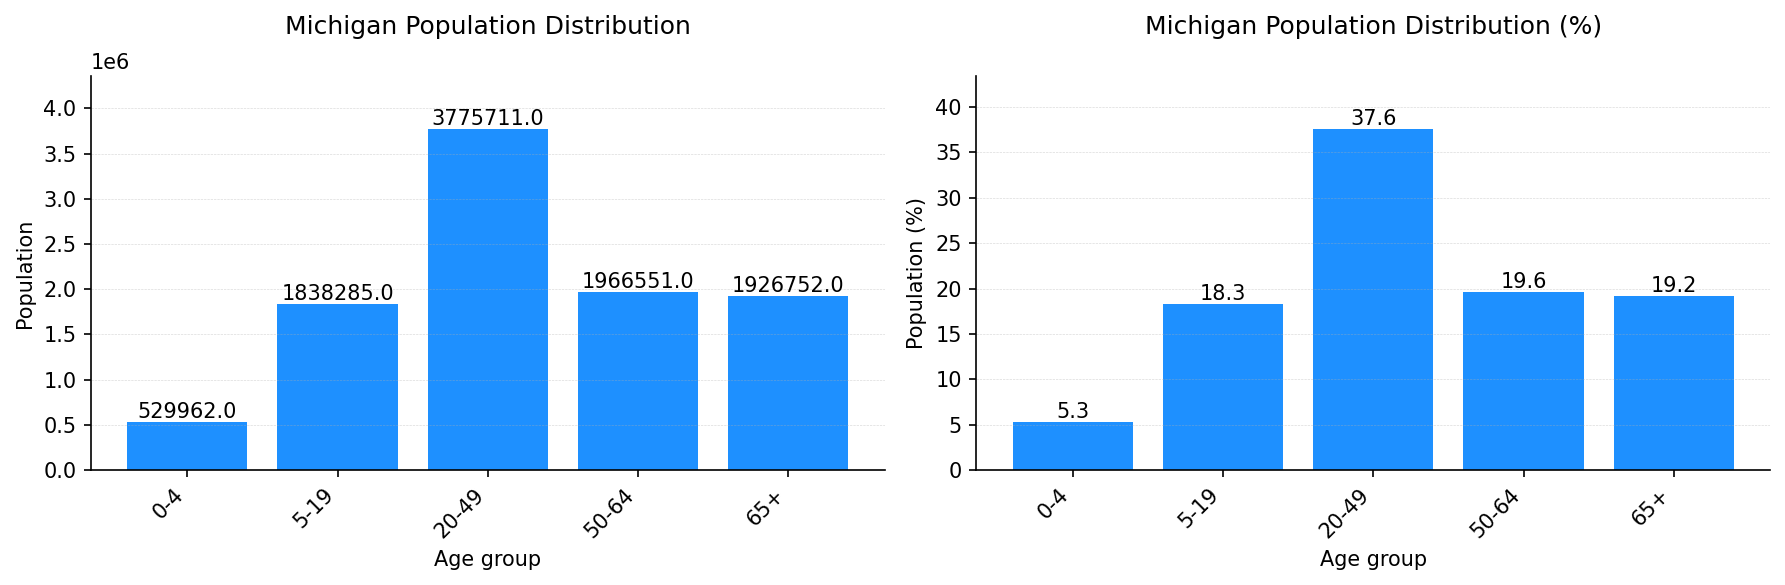

In [5]:
from epydemix.visualization import plot_population, plot_contact_matrix
import matplotlib.pyplot as plt

# TODO: Visualize population distribution and contact matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

# Plot population
plot_population(
    population, ax=axes[0],
    title="Michigan Population Distribution"
)

# Plot contact matrix (e.g., "community" layer)
plot_population(
    population, ax=axes[1],
    title="Michigan Population Distribution (%)",
    show_perc=True
)

plt.tight_layout()

## Task 3: Run Simulations and Visualize

Run 50 stochastic simulations over 1 year, seeding with approximately 10 infected individuals.

In [6]:
import numpy as np

# TODO: Run 50 simulations over 1 year
# Hint: percentage_in_agents = 10 / population.Nk.sum() seeds ~10 infected
results = model.run_simulations(
    start_date="2026-01-01",
    end_date="2026-08-31",
    Nsim=50,
    percentage_in_agents = 10 / population.Nk.sum()  # seed with ~10 infected
)

### Visualize All Compartments Over Time

<Axes: title={'center': 'SEIR Epidemic Trajectory'}>

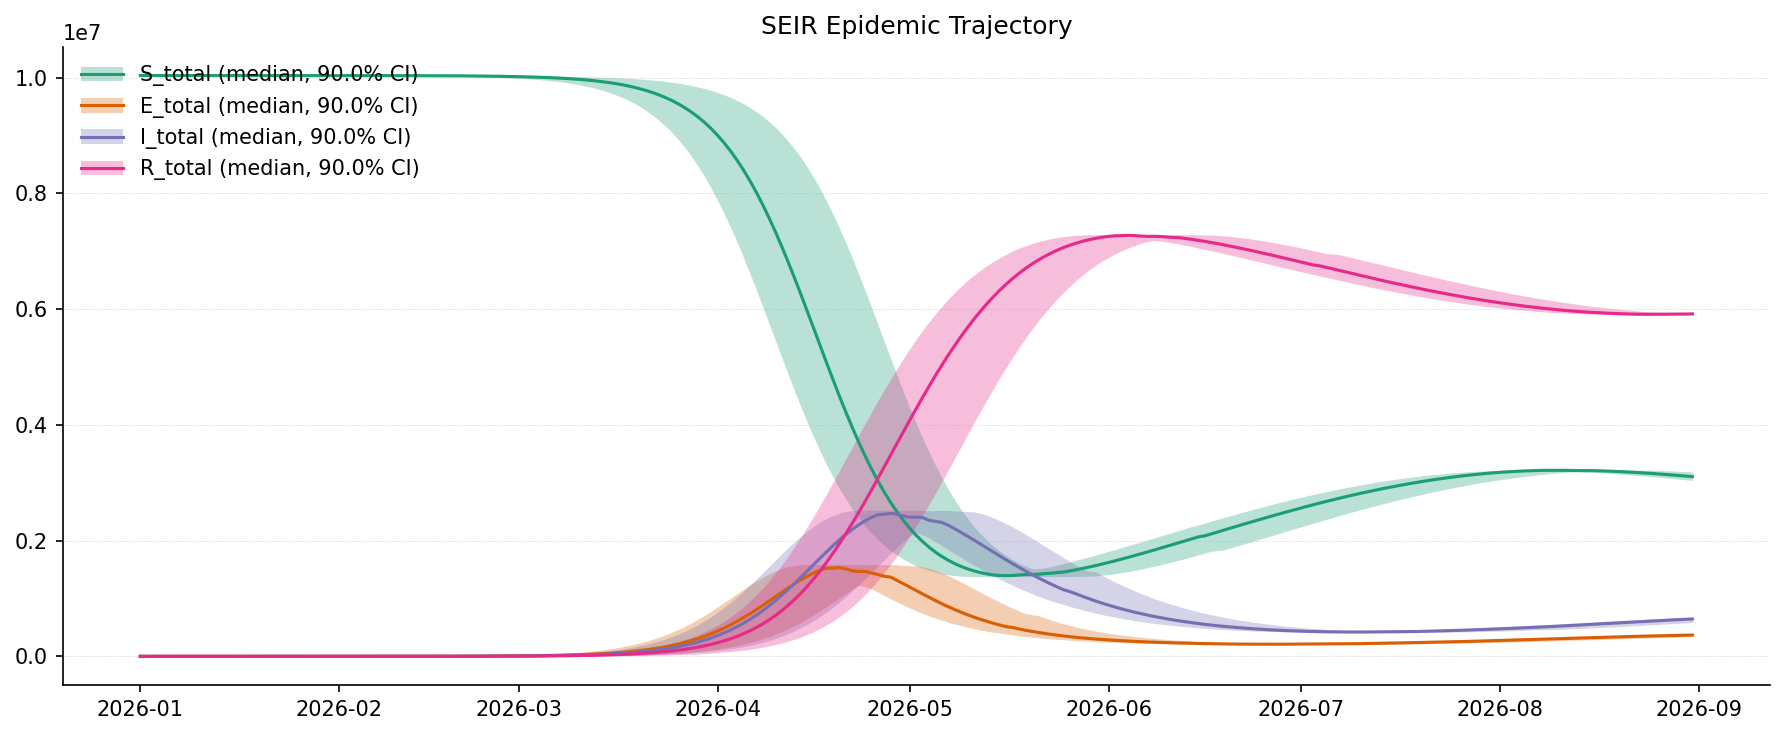

In [7]:
from epydemix.visualization import plot_quantiles

# TODO: Get quantiles and plot all compartments (S, E, I, R)
df_quantiles = results.get_quantiles_compartments()

fig, ax = plt.subplots(figsize = (12, 5), dpi = 150)
# Plot S_total, E_total, I_total, R_total
plot_quantiles(
    df_quantiles, ax = ax,
    columns = ["S_total", "E_total", "I_total", "R_total"], 
    title = "SEIR Epidemic Trajectory"
)

### Infections by Age Group

<Axes: title={'center': 'Infections by Age Group'}>

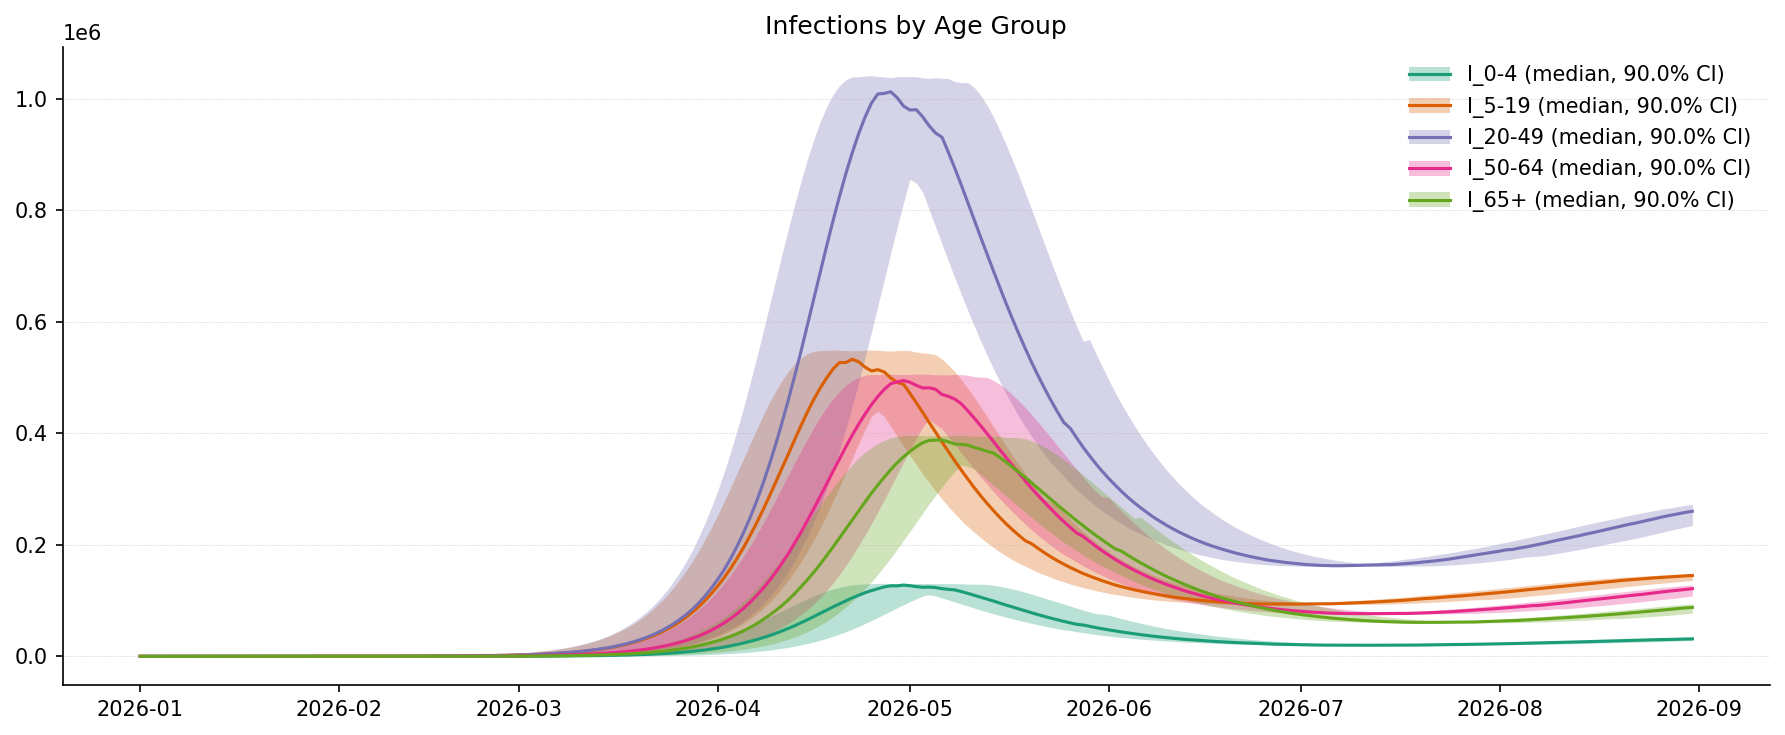

In [8]:
# TODO: Plot infections by age group
# Hint: columns like "I_0-4", "I_5-19", "I_20-49", "I_50-64", "I_65+"
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
plot_quantiles(
    df_quantiles, ax = ax,
    columns = ["I_0-4","I_5-19","I_20-49","I_50-64","I_65+"],
    title = "Infections by Age Group", legend_loc = "upper right"
)

## Task 4: Compare SEIRS vs SEIR

To understand the effect of waning immunity, create a standard SEIR model (without the R → S transition) and compare the dynamics.

In [9]:
# TODO: Create standard SEIR model (no waning immunity)
model_seir = EpiModel(
    name="SEIR Model",
    compartments=["S", "E", "I", "R"]
)

# Add transitions
# S → E: infection (mediated by I)
model_seir.add_transition(
    source="S", target="E",
    params=("beta", "I"),
    kind="mediated"
)

# E → I: progression to infectious
model_seir.add_transition(
    source = "E", target = "I",
    params = "sigma",
    kind = "spontaneous"
)

# I → R: recovery
model_seir.add_transition(
    source = "I", target = "R",
    params = "gamma",
    kind = "spontaneous"
)

# Set parameters (beta, sigma, gamma, omega)
model_seir.add_parameter("beta", 0.03)   # transmission rate
model_seir.add_parameter("sigma", 0.2)   # 1/5 days latent period
model_seir.add_parameter("gamma", 0.1)   # 1/10 days infectious period

# Attach population to the model
model_seir.set_population(population)

# TODO: Run simulations with same parameters
results_seir = model_seir.run_simulations(
    start_date="2026-01-01",
    end_date="2026-08-31",
    Nsim=50,
    percentage_in_agents = 10 / population.Nk.sum()  # seed with ~10 infected
)

### Compare Infected and Susceptible Dynamics

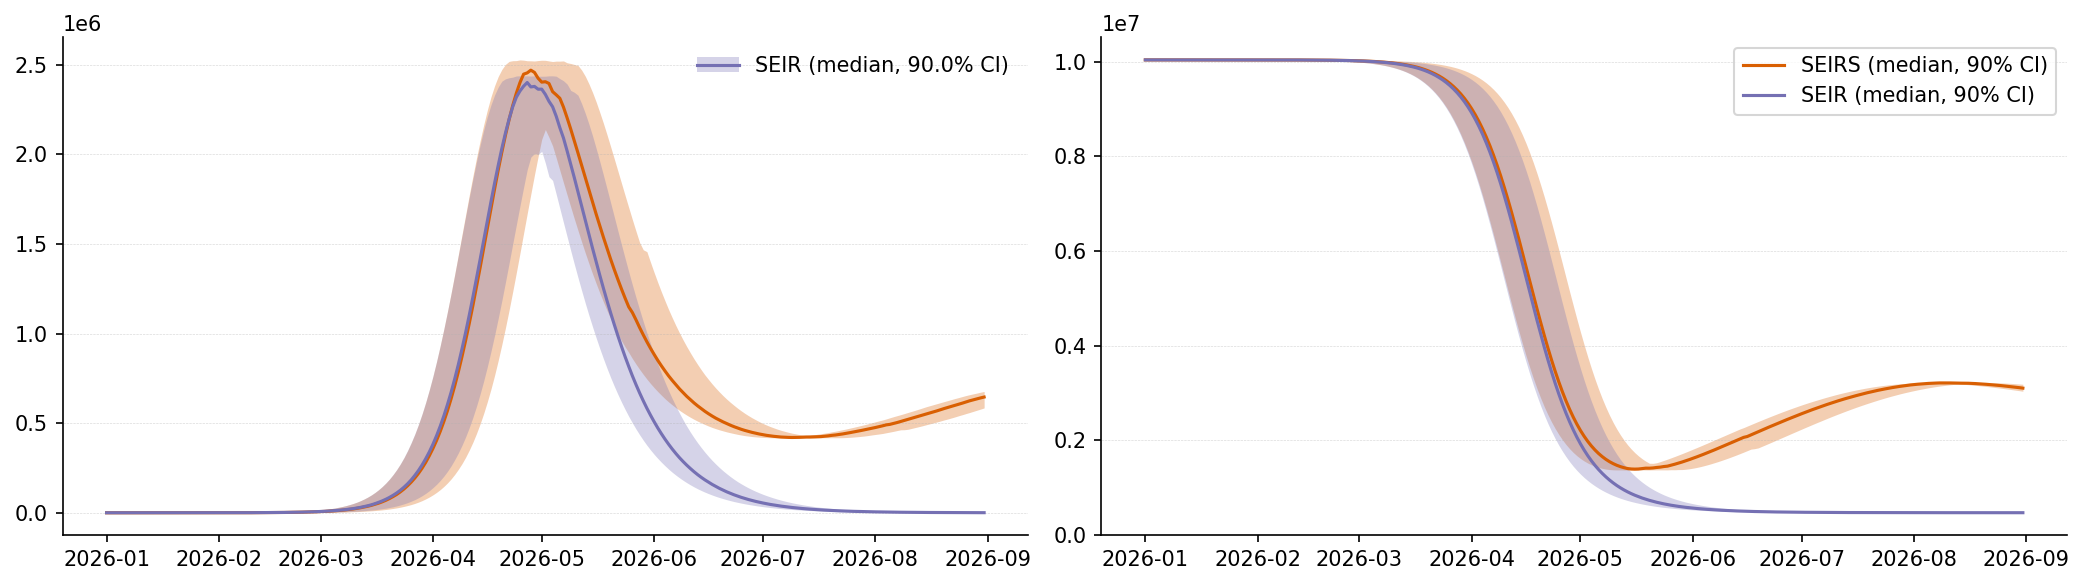

In [18]:
import seaborn as sns
colors = sns.color_palette("Dark2")

# TODO: Compare SEIRS vs SEIR dynamics
# Plot infected over time for both models
# Plot susceptible over time for both models
df_seirs = results.get_quantiles_compartments()
df_seir = results_seir.get_quantiles_compartments()

fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=150)

# Infected comparison (axes[0])
plot_quantiles(
    df_seirs, columns = ["I_total"], colors = colors[1], 
    labels = "SEIRS", ax = axes[0], legend_loc = "upper right"
)
plot_quantiles(
    df_seir, columns = ["I_total"], colors = colors[2],
    labels = "SEIR", ax = axes[0], legend_loc = "upper right"
)

# Susceptible comparison (axes[1])
plot_quantiles(
    df_seirs, columns = ["S_total"], colors = colors[1], 
    ax = axes[1], legend_loc = "upper right",
    labels = "SEIRS (median, 90% CI)", show_legend=False
)
plot_quantiles(
    df_seir, columns = ["S_total"], colors = colors[2],
    ax = axes[1], legend_loc = "upper right",
    labels = "SEIR (median, 90% CI)", show_legend=False
)

axes[1].legend()

plt.tight_layout()

## Discussion

**How does waning immunity affect the long-term dynamics compared to a standard SEIR model?**

*Write your observations here:*

1. What happens to the susceptible pool over time in each model?

2. Does the SEIRS model show any signs of recurrent waves or endemic behavior?

3. What diseases might be better modeled with SEIRS vs SEIR?